# Regression Analysis

In [24]:
import numpy as np
import pandas as pd
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import warnings

from datetime import datetime
from pytz import timezone
import pytz

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

## Load the data

In [49]:
uberx = pd.read_csv('UberPriceTrackX.csv',header=None)
uberx.columns = ['Time','None','Price','Duration','Distance','Wait_Time']
uberx.head()

,Time,None,Price,Duration,Distance,Wait_Time
0,2018-11-08 17:51:51.493805,1541699632,8.71,960,3.27,4
1,2018-11-08 17:55:56.128564,1541699877,8.71,960,3.27,3
2,2018-11-08 17:56:57.918118,1541699939,8.71,960,3.27,2
3,2018-11-08 17:57:59.659881,1541700001,8.71,960,3.27,2
4,2018-11-08 17:59:01.625413,1541700063,8.71,960,3.27,4


## Convert time to Local Time

In [50]:
def time_converter(Data):
    
    """
    Converts given time from UTC to specified timezone
    """
    date = list(Data['Time'])

    converted_date = []
    
    for date in date:
        converted_date.append(convert_time(date))

    Data['Converted Time'] = converted_date
    Data_df = Data[['Time','Converted Time','Price','Duration','Distance','Wait_Time']]
    
    return Data_df, converted_date

def convert_time(dt):
    
    """
    Converts given time from UTC to specified timezone
    Also removes pytz timezone information as to not mess with plotting
    """
    
    date_format='%Y-%m-%d %H:%M:%S.%f'

    date_current_utc = datetime.strptime(dt, date_format)
    date_current_utc = pytz.utc.localize(date_current_utc).astimezone(pytz.UTC)
    
    date_changed = date_current_utc.astimezone(timezone('US/Pacific'))
    
    # Remove timezone information cause it messes with the plotting
    date_changed = date_changed.replace(tzinfo=None)
    return date_changed

In [51]:
Data_X, Converted_Date_X = time_converter(uberx)

### Obtain daily time values for the Weekdays

In [72]:
def get_hour_minute(s): 
    hours = s['Converted Time'].dt.hour.map(str)
    minutes = s['Converted Time'].dt.minute.map(str)
    
    hour_minute = hours + ':' + minutes
    s = []
    for i in hour_minute:
        s.append(datetime.strptime(i, '%H:%M'))
    return s

def get_day(Uber_data):
    Uber_data['days'] = pd.to_datetime(Uber_data['Converted Time']).dt.day_name()
    Uber_data['hour_minute'] = get_hour_minute(Uber_data)
    return Uber_data

In [136]:
# Find out what day it is for each record
Data_X = get_day(Data_X)

# Remove Saturday and Sunday
Data_X_Weekdays = Data_X.drop(Data_X[(Data_X['days'] == 'Saturday') | (Data_X['days'] == 'Sunday')].index)

# Drop 'Time, 'Converted Time', and 'days' columns to clean up
Data_X_Weekdays = Data_X_Weekdays.drop(columns=['Time','Converted Time','days'])

# Reset index to clean up
Data_X_Weekdays = Data_X_Weekdays.reset_index(drop=True)

Now let us visualize the distribution of price throughout the day.

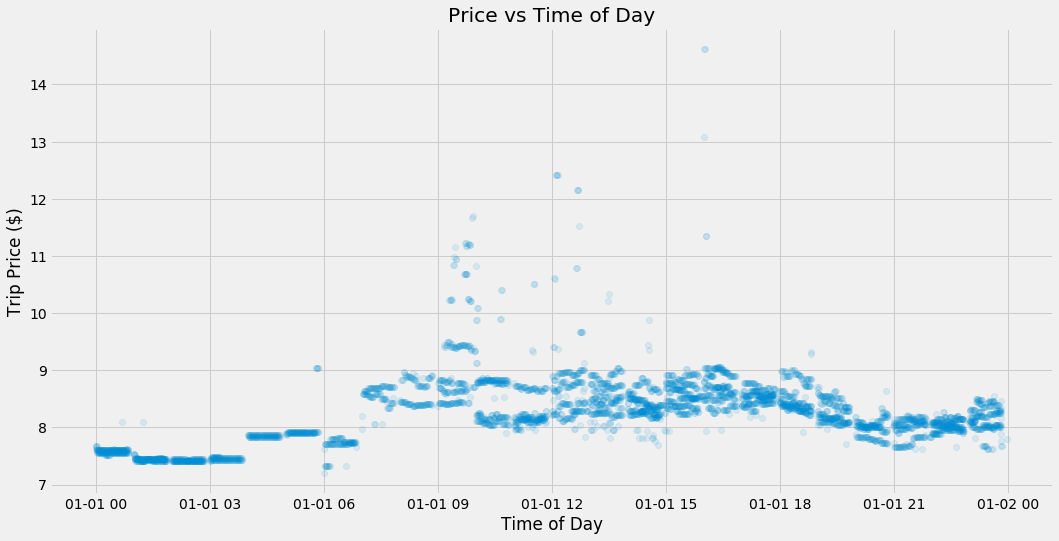

In [154]:
# Simple Plot
plt.figure(figsize=(16,8))

plt.plot_date(Data_X_Weekdays['hour_minute'],Data_X_Weekdays['Price'],alpha=0.1)#,c=Data_X_Weekdays['days'].apply(lambda x: colors[x]))
plt.title('Price vs Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Trip Price ($)')

plt.show()

We can observe that time of day has a cyclical relationship with price. Generally, prices go up during the day, and go down deep at night when people are home or asleep. Hence, it would not make sense to directly utilize this as an independent variable in an Ordinary Least Squares analysis. Instead, we categorized the day into bins and treat them as categorical data. Based on and general information and the plot above, we can divide the data into four mutually exclusive categories - AM Peak (6AM to 9AM), Midday (9AM to 4PM), PM Peak (4PM to 8PM), and Night (8PM to 6AM). Now, this categorization can be subjective and can be tweaked in many ways. For the purpose of this exercise, these are the categories that will be used.

### Convert time data to categorical

Because they are mutually exclusive, we will need 3 columns to represent the 4 categories. The columns will be 'AM Peak', 'Midday', and 'PM Peak'. If the value is 0 for all three columns, that would indicate 'Night'.

In [145]:
# Create New Column Initialized to 'Night'
Data_X_Weekdays['Time_Of_Day'] = '0_Night'

# Categorize AM Peak
Data_X_Weekdays.loc[(Data_X_Weekdays['hour_minute'] > '1900-01-01 06:00:00') &
                    (Data_X_Weekdays['hour_minute'] < '1900-01-01 09:00:00'),'Time_Of_Day'] = 'AM_Peak'

# Categorize Midday
Data_X_Weekdays.loc[(Data_X_Weekdays['hour_minute'] > '1900-01-01 09:00:00') &
                    (Data_X_Weekdays['hour_minute'] < '1900-01-01 16:00:00'),'Time_Of_Day'] = 'Midday'

# Categorize PM Peak
Data_X_Weekdays.loc[(Data_X_Weekdays['hour_minute'] > '1900-01-01 16:00:00') &
                    (Data_X_Weekdays['hour_minute'] < '1900-01-01 20:00:00'),'Time_Of_Day'] = 'PM_Peak'

# View
Data_X_Weekdays.head()

,Price,Duration,Distance,Wait_Time,hour_minute,Time_Of_Day
0,8.71,960,3.27,4,1900-01-01 09:51:00,Midday
1,8.71,960,3.27,3,1900-01-01 09:55:00,Midday
2,8.71,960,3.27,2,1900-01-01 09:56:00,Midday
3,8.71,960,3.27,2,1900-01-01 09:57:00,Midday
4,8.71,960,3.27,4,1900-01-01 09:59:00,Midday


Then, we can use the pandas function 'get_dummies' to quickly generate a one-hot encoded DataFrame as shown below.

In [146]:
Time_of_Day = pd.get_dummies(Data_X_Weekdays['Time_Of_Day'],drop_first=True,prefix='TOD')
Time_of_Day.head()

,TOD_AM_Peak,TOD_Midday,TOD_PM_Peak
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


In [147]:
# Merge the two DataFrames
model_df = pd.merge(Data_X_Weekdays,Time_of_Day,left_index=True,right_index=True)

# Drop 'hour_minute' and 'Time_Of_Day' to clean up
model_df = model_df.drop(columns=['hour_minute','Time_Of_Day'])

# Quick View
Data_X_Weekdays.head()

,Price,Duration,Distance,Wait_Time,hour_minute,Time_Of_Day
0,8.71,960,3.27,4,1900-01-01 09:51:00,Midday
1,8.71,960,3.27,3,1900-01-01 09:55:00,Midday
2,8.71,960,3.27,2,1900-01-01 09:56:00,Midday
3,8.71,960,3.27,2,1900-01-01 09:57:00,Midday
4,8.71,960,3.27,4,1900-01-01 09:59:00,Midday


Now the data is ready for regression analysis.

### Let's first take a look at the correlation matrices.

In [148]:
model_df.corr()

,Price,Duration,Distance,Wait_Time,TOD_AM_Peak,TOD_Midday,TOD_PM_Peak
Price,1.000000,0.700839,0.484140,-0.169339,0.012708,0.421560,0.225994
Duration,0.700839,1.000000,0.329317,-0.268228,0.184667,0.358283,0.302478
Distance,0.484140,0.329317,1.000000,-0.033255,-0.062323,0.213913,0.007354
Wait_Time,-0.169339,-0.268228,-0.033255,1.000000,0.004404,-0.099490,-0.102817
TOD_AM_Peak,0.012708,0.184667,-0.062323,0.004404,1.000000,-0.189939,-0.132777
TOD_Midday,0.421560,0.358283,0.213913,-0.099490,-0.189939,1.000000,-0.380781
TOD_PM_Peak,0.225994,0.302478,0.007354,-0.102817,-0.132777,-0.380781,1.000000


Here, we observe that Duration, Distance, and Time of Day (specifically Midday) have the highest correlation to Price.

However, in the setup of our data collection, distance was fixed for each API request. We hence look at Duration and Time of Day. Although the correlation coefficients vary greatly among the three Time of Day columns (0.01 to 0.42), we will first include all three in this exercise and improve the model as we go along. We observe that Duration and Time have relatively low correlation with each other (0.18 to 0.36). We thus begin regression analysis with Duration as the predictor.

Let's visualize these two features.

**Price vs Estimated Trip Duration**

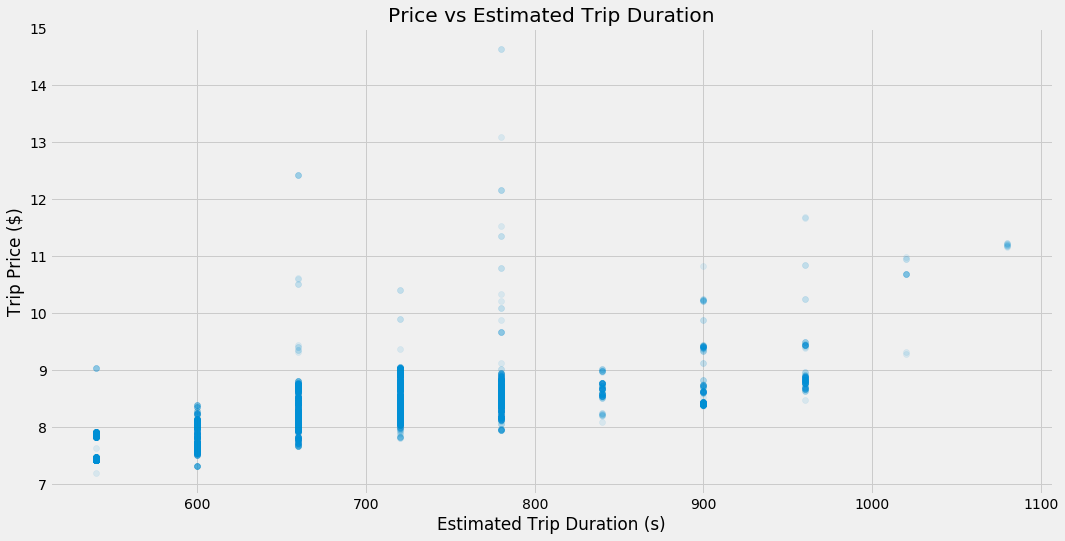

In [149]:
plt.figure(figsize=(16,8))
plt.scatter(Data_X_Weekdays['Duration'],Data_X_Weekdays['Price'],alpha=0.1)
plt.title('Price vs Estimated Trip Duration')
plt.xlabel('Estimated Trip Duration (s)')
plt.ylabel('Trip Price ($)')

plt.show()

**Price vs Time of Day**

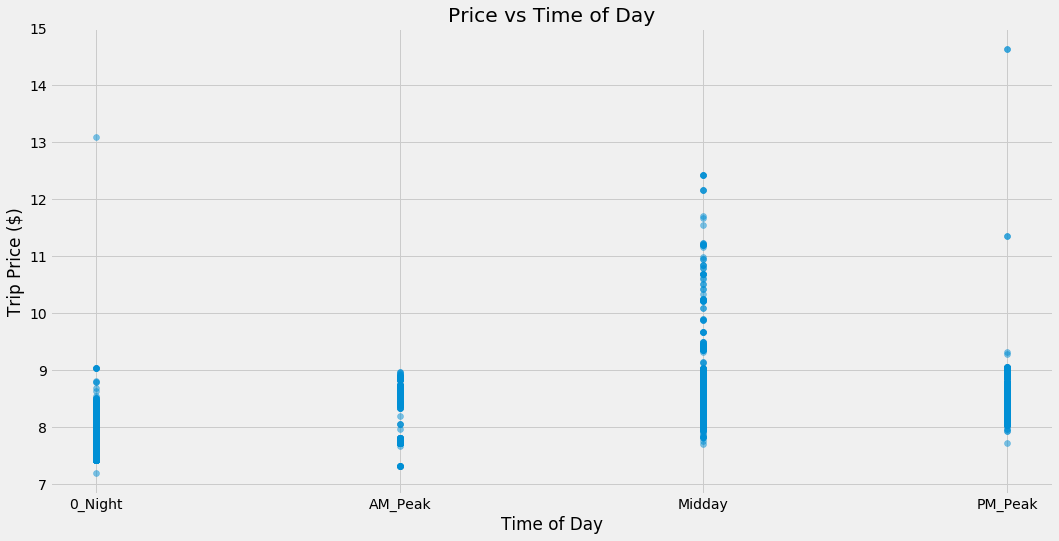

In [150]:
data_sorted = Data_X_Weekdays.sort_values(by=['Time_Of_Day'])

plt.figure(figsize=(16,8))

plt.scatter(x=data_sorted['Time_Of_Day'],y=data_sorted['Price'],alpha=0.5)
plt.title('Price vs Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Trip Price ($)')

plt.show()

The overall shape of Price vs Estimated Trip Duration validates the correlation calculated above. The Time of Day variable also has a similar trend present, but not as strongly.

### Now we fit an OLS Regression Model.
  
First, we start with Duration as the sole predictor, being the feature most correlated to price.

In [151]:
model = ols(formula="Price ~ Duration", data=model_df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     4567.
Date:                Fri, 14 Dec 2018   Prob (F-statistic):               0.00
Time:                        00:48:48   Log-Likelihood:                -2389.2
No. Observations:                4733   AIC:                             4782.
Df Residuals:                    4731   BIC:                             4795.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.5927      0.040    139.615      0.000       5.514       5.671
Duration       0.0039   5.72e-05     67.579      0.000       0.004       0.004
==============================================================================
Omnibus:                     4410.959   Durbin-Watson:                   0.242
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           367206.830
Skew:                           4.197   Prob(JB):                         0.00
Kurtosis:                      45.327   Cond. No.                     4.81e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.81e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We can see that the regression model here performs decently, but R-squared is relatively low. This could indicate that the relationship is not linear and/or that there are other factors affecting price. Let us try introducing another variable, the Time of Day.

In [152]:
model = ols(formula="Price ~ Duration + TOD_AM_Peak + TOD_Midday + TOD_PM_Peak", data=model_df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     1408.
Date:                Fri, 14 Dec 2018   Prob (F-statistic):               0.00
Time:                        00:48:50   Log-Likelihood:                -2131.9
No. Observations:                4733   AIC:                             4274.
Df Residuals:                    4728   BIC:                             4306.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.0017      0.047    128.689      0.000       5.910       6.093
Duration        0.0030   7.62e-05     39.882      0.000       0.003       0.003
TOD_AM_Peak    -0.0297      0.027     -1.099      0.272      -0.083       0.023
TOD_Midday      0.3354      0.017     19.901      0.000       0.302       0.368
TOD_PM_Peak     0.2293      0.019     12.087      0.000       0.192       0.267
==============================================================================
Omnibus:                     4751.630   Durbin-Watson:                   0.273
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           525460.201
Skew:                           4.661   Prob(JB):                         0.00
Kurtosis:                      53.770   Cond. No.                     6.41e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We observe that the adjusted R-squared fit improved from 0.491 to 0.543. Although this is an improvement, this also means that there is much to the data left unexplained by our independent variables.

We also observe that most of the P-values of the coefficient estimators are very low, indicating strength in the estimators for the coefficients of the regression. However, the p-value for the slope of 'TOD_AM_Peak' is very high at 0.272. This means that we cannot reject the null hypothesis that the slope of 'TOD_AM_Peak' equals zero. Intuitively, this makes sense as the correlation coefficient we obtained for this variable in the previous section was low at 0.01. Hence, we could opt to remove the variable from the model, which is shown below.

In [153]:
model = ols(formula="Price ~ Duration + TOD_Midday + TOD_PM_Peak", data=model_df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     1877.
Date:                Fri, 14 Dec 2018   Prob (F-statistic):               0.00
Time:                        01:07:40   Log-Likelihood:                -2132.5
No. Observations:                4733   AIC:                             4273.
Df Residuals:                    4729   BIC:                             4299.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.0218      0.043    140.372      0.000       5.938       6.106
Duration        0.0030   6.74e-05     44.485      0.000       0.003       0.003
TOD_Midday      0.3442      0.015     23.229      0.000       0.315       0.373
TOD_PM_Peak     0.2386      0.017     14.018      0.000       0.205       0.272
==============================================================================
Omnibus:                     4757.406   Durbin-Watson:                   0.273
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           526474.905
Skew:                           4.670   Prob(JB):                         0.00
Kurtosis:                      53.817   Cond. No.                     5.59e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We can see here that after removing 'TOD_AM_Peak' as a variable, the adjusted R-squared stayed the same, but other indicators like AIC and BIC improved showing a reduction in overfitting and a better bias-variance balance than the previous model, without reducing the quality of the regression.

Looking deeper into the characteristics of the final model, we observe that the value of the intercept is quite high. This value of intercept means that if all the variables have a value of 0, the price would be \$6.02. Because the AM Peak and Night Time of Day categories are not included in the model, the price values for these two times of day are incorporated in the intercept. This could also indicate a base price that Uber imposes and/or that there are other factors not accounted for in the model, as the R-squared fit suggests.

Furthermore, the coefficient for duration is very low at 0.003. This is primarily due to the fact that the values of the Duration variable are very high, with its units expressed in seconds. Depending on the purpose of the regression, one way to address this is to standardize all the variables.

On the other hand, TOD_Midday and TOD_PM_Peak are directly comparable since their values are only either 0 or 1. Looking at the values of their coefficients, we can surmise that whether a trip happens during midday has a bigger impact to price than whether it happens during the PM peak. Looking back to the distribution of price vs time of day, this also makes sense as the most high-priced trips seem to occur during midday.